
## Chapter 4. Classification : Linear Regression
### Classification 타입 Supervised Learning 모델

In [2]:
# 패키지 imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf 

# notebook에 직접 그래프를 plot  
%matplotlib inline

In [3]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)
print("numpy:", np.__version__, "  pandas:", pd.__version__, "  seaborn:", sns.__version__) 

C:\Users\schiz\anaconda3\python.exe
3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
numpy: 1.18.1   pandas: 1.0.1   seaborn: 0.10.0


In [4]:
# 'Default' 데이터 Load  
Default = pd.read_excel('../Data/Default.xlsx')

# 제약 조건1
'레이블이 default입니다. Yes를 1로 No를 0으로 변환하세요. student 입력변수 의 Yes 와 No도 똑같이 하세요.'

왜냐하면 scikit learn 모델들은 `numeric` feature 만 허용하기에 카테고리 변수들은 dummy variable을 사용해 실수로 encoding 하여 사용해야 함

In [5]:
Default_enc = pd.get_dummies(Default, drop_first=True)
Default_enc.head()

,Unnamed: 0,balance,income,default_Yes,student_Yes
0,1,729.526495,44361.625074,0,0
1,2,817.180407,12106.134700,0,1
2,3,1073.549164,31767.138947,0,0
3,4,529.250605,35704.493935,0,0
4,5,785.655883,38463.495879,0,0


# 제약 조건2
'임계치를 적절히 잡아 분류를 하세요 정답 없어요'


해결책: threshold를 0.1로 임의 초기화할 때,이에 대응하는 balance를 구한다. 그리고 이 값을 기준으로 분류할 수 있다.

단계1: 가장 의미있는 입력변수를 찾는다

단계2: 어림곡선의 모수를 도출한다

단계3: 주어진 모수를 통해 찾고자 하는 balance를 구하고 이를 기준삼아 분류한다.

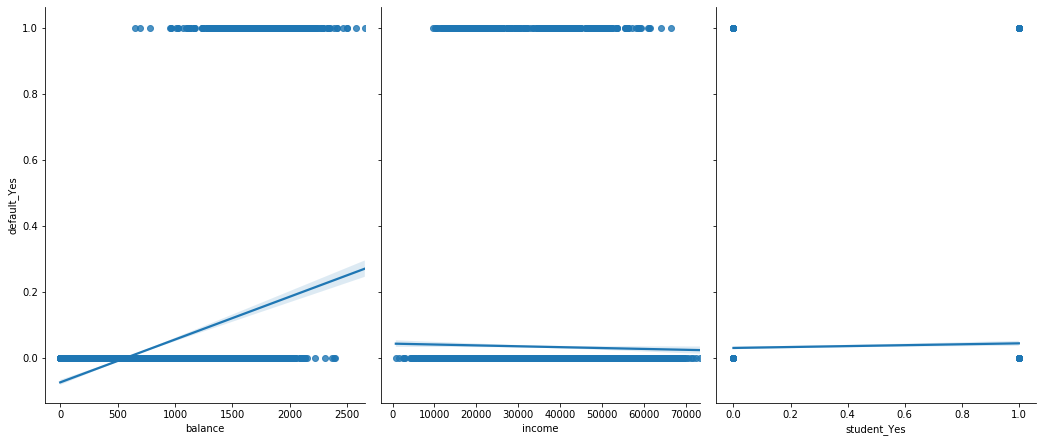

In [40]:
sns.pairplot(data=Default_enc, x_vars=['balance','income','student_Yes'], y_vars=['default_Yes'], height=6, aspect=0.8, kind='reg')

In [41]:
lm = smf.ols(formula='default_Yes ~ balance', data=Default_enc)
lm_learned = lm.fit()
lm_learned.params

Intercept   -0.075192
balance      0.000130
dtype: float64

# (더 생각해본 것)

확률값(0~1)에 대해 선형회귀를 통해 분류할때,결과값이 음수값을 가지는 한계를

위에서 도출된 Intercept만큼의 상수를 어림곡선에 더해줌으로서,

simple linear regression에 한하여 해결할 수 있음을 생각해 보았다.

(단, 아래의 코드들에는 적용하지 않음)

In [49]:
# threshold를 주어진 어림곡선의 형태에 따라 0.1로 설정할때, default_Yes=0.1에 대응하는 balance를 구하자
special_balance = (0.1 - lm_learned.params.Intercept) / lm_learned.params.balance 
special_balance

1342.2212239908708

In [50]:
#위에서 도출한 특정 임계치에 대한 balance값을 기준으로 분류가능

Default_enc['classified']=np.where(Default_enc['balance']>special_balance, 1, 0)
Default_enc.head()

,Unnamed: 0,balance,income,default_Yes,student_Yes,classified
0,1,729.526495,44361.625074,0,0,0
1,2,817.180407,12106.134700,0,1,0
2,3,1073.549164,31767.138947,0,0,0
3,4,529.250605,35704.493935,0,0,0
4,5,785.655883,38463.495879,0,0,0


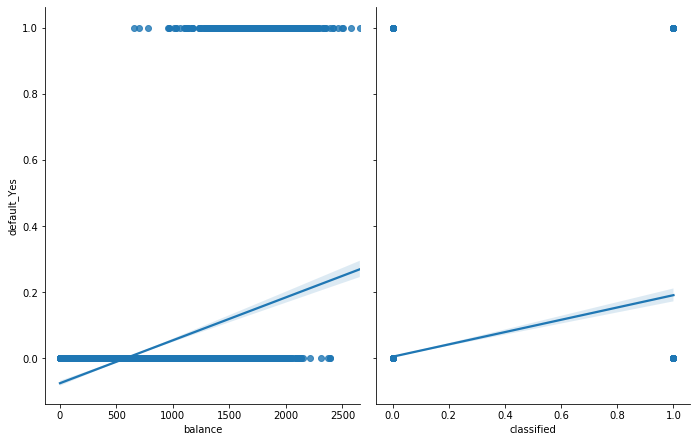

In [55]:
sns.pairplot(data=Default_enc, x_vars=['balance','classified'], y_vars=['default_Yes'], height=6, aspect=0.8, kind='reg')

## 결과적으로,
## 좌측의 개별사례(또는 점들)이 0 또는 1로 우측에 분류된 것을 볼 수 있다.

## 한편, 
## default_Yes==1인 채무불이행자임에도 채무이행자로, 
## default_Yes==0인 채무이행자임에도 채무불이행자로,
## 잘못 분류된 사실을 확인할수있다.

이때, 입력변수가 classified로 잡혀서 나오는 어림곡선은 논외이다.

# 제약 조건3

'Default 데이터의 샘플들을 학습용(Training) 데이터(70%)와 평가용(Test) 데이터 비율(30%)을 7:3으로 나누어 학습용 데이터로 학습한 후 평가용 데이터로 성능을 측정하세요.'

'데이터를 학습용과 평가용으로 나눌 때 레이블이 default의 'no'와 'yes'의 분포가 양쪽에 균등하게 포함되도록 하세요. 즉 원래 Default 데이터에 10000개 샘플이 있는데, 그 중 default 값이 No인 것이 9667, Yes 인 것이 333 입니다. 이 No : Yes 비율이 학습용 데이터와 평가용 데이터와 비슷하게 적용되어야합니다.'

### Idea
Default_enc에서 default_Yes와 default_No를 구분한다.

그 후 각각 70%씩 추출하여 Training dataframe을 만들고, 나머지로는 평가용 데이터 프레임을 만든다.

최종적으로 accuracy를 통해서 성능을 비교한다.

In [56]:
#print(round(9667*0.7)) 
#결과값 6767
#print(round(333*0.7))
#결과값 233

DefaultNo_set=Default_enc.query('default_Yes==0')
DefaultYes_set=Default_enc.query('default_Yes==1')

Training_set=pd.concat([DefaultNo_set[0:6767],DefaultYes_set[0:233]],ignore_index=True)
Testing_set=pd.concat([DefaultNo_set[6767:],DefaultYes_set[233:]],ignore_index=True)


## 먼저 Traing_set에서 분류를 위한 balance 도출 및 분류
### 이때 threshold(임계치)를 재설정함에 있어 앞선 자료를 분석해 보겠다. 
직관적으로 default_Yes(채무불이행자)는 앞써 구한 기준값 balance(약 1300)보다 더 우측에 밀집되어있다.

따라서,0.1보다 증가한 0.2로 임계치(threshold) 설정해본다.

다시
전처리 똑같이 분류를 위한 특정 balance를 구한다.

In [57]:
lm = smf.ols(formula='default_Yes ~ balance', data=Training_set)
lm_learned = lm.fit()

# threshold를 0.2로 할때, 즉 default_Yes=0.2에 대응하는 balance를 구하자
special_balance = (0.2 - lm_learned.params.Intercept) / lm_learned.params.balance 
Training_set['classified']=np.where(Training_set['balance']>special_balance, 1, 0)
Training_set.head()

,Unnamed: 0,balance,income,default_Yes,student_Yes,classified
0,1,729.526495,44361.625074,0,0,0
1,2,817.180407,12106.134700,0,1,0
2,3,1073.549164,31767.138947,0,0,0
3,4,529.250605,35704.493935,0,0,0
4,5,785.655883,38463.495879,0,0,0


In [58]:
(Training_set.default_Yes == Training_set.classified).mean()

0.9705714285714285

### 위에서 구한 특정 balance를 바탕으로 Testing_set을 분류해보자!

In [61]:
Testing_set['classified']=np.where(Testing_set['balance']>special_balance, 1, 0)
Testing_set.head()

,Unnamed: 0,balance,income,default_Yes,student_Yes,classified
0,7008,824.518401,20689.724223,0,1,0
1,7009,358.647642,56331.778768,0,0,0
2,7010,1393.369463,43439.674070,0,0,0
3,7011,332.413826,37129.151178,0,0,0
4,7012,1215.088950,39002.496965,0,0,0


In [62]:
(Testing_set.default_Yes == Testing_set.classified).mean()

0.97

### 97.05%에서 97%로 정확도가 0.05%p 소폭 하락하였다~
### 정확성이 크게 차이나지 않는다는 점에서, 앞선 분류모델은 overfit 또는 underfit이 아니라고 볼수도 있다

# 제약조건4

평가용 데이터에 대한 Confusion Matrix를 만들어 성능평가를 하세요.

In [63]:
from sklearn import metrics

In [64]:
conf_mat = metrics.confusion_matrix(Training_set.default_Yes, Training_set.classified) 
print(conf_mat)

[[6759    8]
 [ 198   35]]


### Accuracy  97.05%

In [65]:
(conf_mat[0,0] + conf_mat[1,1]) /conf_mat.sum()   # confusion matrix에서 Accuracy 계산 

0.9705714285714285

### Sensitivity 15.02%

높은 정확도에 비해 민감도가 낮은 것은, 데이터의 편향적인 경향에 기인한다고 생각한다.
왜냐하면, 정확도에 비례하는 TN, TP의 합이 전체에서 차지하는 비중이 높음에도,
민감도가 낮기 위해선 TN 또는 TP가 균등하지 않고 한쪽에 쏠려야하기 때문이다.

In [68]:
print((conf_mat[1,1] / (conf_mat[1,0] + conf_mat[1,1])))

0.15021459227467812


### Precision 81.39%

In [70]:
print((conf_mat[1,1] / (conf_mat[0,1] + conf_mat[1,1])))

0.813953488372093
